In [1]:
import pandas as pd

# Load the dataset
file_path = 'CollinsEtAl_2018_PNAS.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,subno,block,ns,time,stimseq,imageseq,folderseq,iterseq,corAseq,choice,key,cor,rew,rt,"condition (HC=0,SZ=1)",pcor,delay
0,1,1,5,1,1,1,1,1,1,2,13,0,0,0.758829,1,NaN,NaN
1,1,1,5,2,5,5,1,1,3,1,14,0,0,0.678557,1,NaN,NaN
2,1,1,5,3,3,3,1,1,2,1,14,0,0,0.584314,1,NaN,NaN
3,1,1,5,4,1,1,1,2,1,-1,-1,-1,-1,-1.000000,1,0.0,NaN
4,1,1,5,5,2,2,1,1,1,3,15,0,0,0.782260,1,NaN,NaN


In [2]:

# Handle missing values
data_clean = data.dropna(subset=['cor', 'rew', 'rt'])

# Display the cleaned dataset
data_clean.head()


,subno,block,ns,time,stimseq,imageseq,folderseq,iterseq,corAseq,choice,key,cor,rew,rt,"condition (HC=0,SZ=1)",pcor,delay
0,1,1,5,1,1,1,1,1,1,2,13,0,0,0.758829,1,NaN,NaN
1,1,1,5,2,5,5,1,1,3,1,14,0,0,0.678557,1,NaN,NaN
2,1,1,5,3,3,3,1,1,2,1,14,0,0,0.584314,1,NaN,NaN
3,1,1,5,4,1,1,1,2,1,-1,-1,-1,-1,-1.000000,1,0.0,NaN
4,1,1,5,5,2,2,1,1,1,3,15,0,0,0.782260,1,NaN,NaN


In [3]:
# Fill missing values in pcor and delay with zeros (or any appropriate value based on the context of the experiment)
data_clean['pcor'].fillna(0, inplace=True)
data_clean['delay'].fillna(0, inplace=True)

# Display the cleaned dataset
data_clean.head()


/var/folders/qc/34thgm6d2ql1svk_jvxdmyv80000gn/T/ipykernel_81161/2547018765.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['pcor'].fillna(0, inplace=True)
/var/folders/qc/34thgm6d2ql1svk_jvxdmyv80000gn/T/ipykernel_81161/2547018765.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,subno,block,ns,time,stimseq,imageseq,folderseq,iterseq,corAseq,choice,key,cor,rew,rt,"condition (HC=0,SZ=1)",pcor,delay
0,1,1,5,1,1,1,1,1,1,2,13,0,0,0.758829,1,0.0,0.0
1,1,1,5,2,5,5,1,1,3,1,14,0,0,0.678557,1,0.0,0.0
2,1,1,5,3,3,3,1,1,2,1,14,0,0,0.584314,1,0.0,0.0
3,1,1,5,4,1,1,1,2,1,-1,-1,-1,-1,-1.000000,1,0.0,0.0
4,1,1,5,5,2,2,1,1,1,3,15,0,0,0.782260,1,0.0,0.0


In [7]:
import numpy as np
import scipy.optimize as opt

# Define the static noise inference model
def static_noise_likelihood(params, data, n_actions=3):
    epsilon = params[0]
    likelihood = 0

    for index, row in data.iterrows():
        action_prob = (epsilon / n_actions) + (1 - epsilon) * row['cor']
        if action_prob > 0:  # Ensure we don't take log of zero
            likelihood += np.log(action_prob)

    return -likelihood

# Define the dynamic noise inference model
def dynamic_noise_likelihood(params, data, n_actions=3):
    T_0_1 = params[0]
    T_1_0 = params[1]
    likelihood = 0
    lambda_0 = 0.5  # Initial probability of being in the random state

    for index, row in data.iterrows():
        lambda_1 = 1 - lambda_0
        action_prob = (lambda_0 / n_actions) + (lambda_1) * row['cor']
        if action_prob > 0:  # Ensure we don't take log of zero
            likelihood += np.log(action_prob)

        # Update lambda_0 based on transition probabilities
        lambda_0 = (lambda_0 * T_1_0 + lambda_1 * T_0_1) / (
            lambda_0 * T_1_0 + lambda_1 * T_0_1 + lambda_0 * (1 - T_1_0) + lambda_1 * (1 - T_0_1)
        )

    return -likelihood

# Fit the static noise inference model with better initial guess
initial_params_static = [0.5]
bounds_static = [(0.001, 1)]  # Avoid zero to prevent degenerate solutions
result_static = opt.minimize(static_noise_likelihood, initial_params_static, args=(data_clean,), bounds=bounds_static)
epsilon_hat = result_static.x[0]

# Fit the dynamic noise inference model with better initial guess
initial_params_dynamic = [0.5, 0.5]
bounds_dynamic = [(0.001, 1), (0.001, 1)]  # Avoid zero to prevent degenerate solutions
result_dynamic = opt.minimize(dynamic_noise_likelihood, initial_params_dynamic, args=(data_clean,), bounds=bounds_dynamic)
T_0_1_hat, T_1_0_hat = result_dynamic.x

# Print the estimated parameters
print("Static noise model epsilon:", epsilon_hat)
print("Dynamic noise model T_0_1:", T_0_1_hat, "T_1_0:", T_1_0_hat)

# Check optimization success
print("Static noise model optimization success:", result_static.success)
print("Dynamic noise model optimization success:", result_dynamic.success)


Static noise model epsilon: 0.2950431592308383
Dynamic noise model T_0_1: 0.2914848634015728 T_1_0: 0.3035498702874344
Static noise model optimization success: True
Dynamic noise model optimization success: True


In [8]:
# Calculate AIC for the static noise model
aic_static = 2 * len(result_static.x) + 2 * result_static.fun

# Calculate AIC for the dynamic noise model
aic_dynamic = 2 * len(result_dynamic.x) + 2 * result_dynamic.fun

print("AIC for static noise model:", aic_static)
print("AIC for dynamic noise model:", aic_dynamic)


AIC for static noise model: 37859.83449418128
AIC for dynamic noise model: 37860.76263704893


/var/folders/qc/34thgm6d2ql1svk_jvxdmyv80000gn/T/ipykernel_81161/318870371.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  individual_aic_diff = data_clean.groupby('subno').apply(lambda x: 2 * len(result_static.x) + 2 * static_noise_likelihood([epsilon_hat], x) - (2 * len(result_dynamic.x) + 2 * dynamic_noise_likelihood([T_0_1_hat, T_1_0_hat], x)))


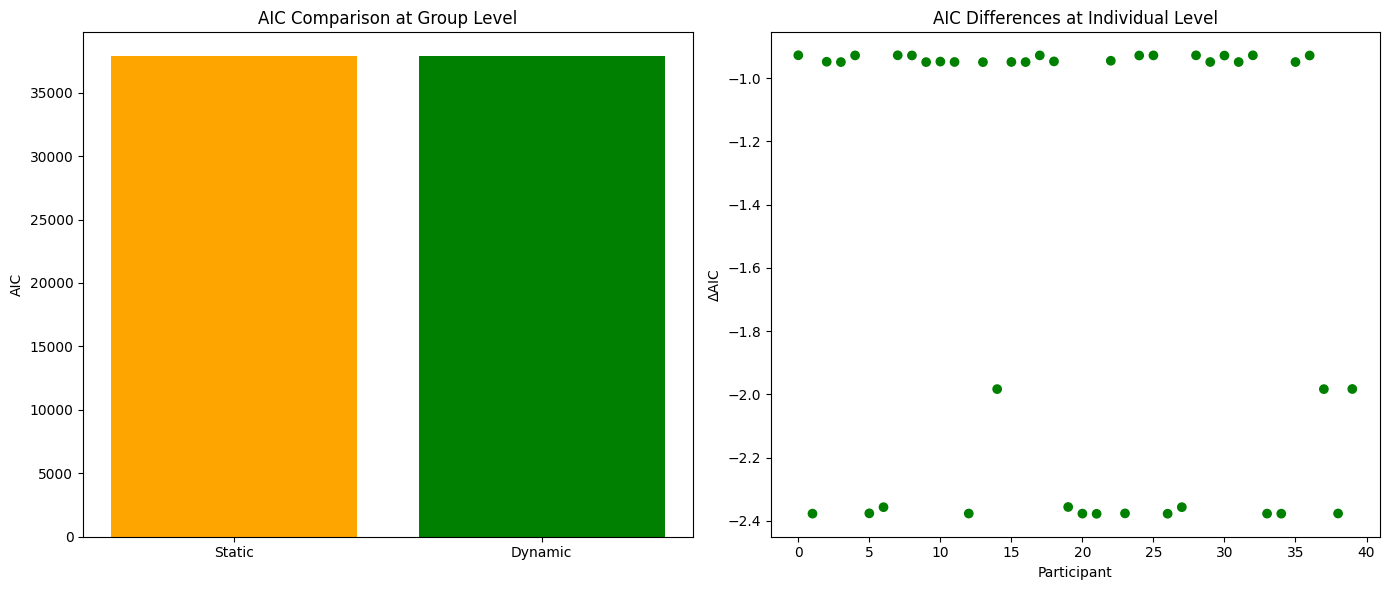

In [10]:
import matplotlib.pyplot as plt

# Calculate AIC for both models
aic_static = 2 * len(result_static.x) + 2 * result_static.fun
aic_dynamic = 2 * len(result_dynamic.x) + 2 * result_dynamic.fun
aic_diff = aic_static - aic_dynamic

# Group level AIC comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(['Static', 'Dynamic'], [aic_static, aic_dynamic], color=['orange', 'green'])
ax[0].set_ylabel('AIC')
ax[0].set_title('AIC Comparison at Group Level')

# Individual level AIC differences
individual_aic_diff = data_clean.groupby('subno').apply(lambda x: 2 * len(result_static.x) + 2 * static_noise_likelihood([epsilon_hat], x) - (2 * len(result_dynamic.x) + 2 * dynamic_noise_likelihood([T_0_1_hat, T_1_0_hat], x)))
ax[1].scatter(range(len(individual_aic_diff)), individual_aic_diff, c=['orange' if x > 0 else 'green' for x in individual_aic_diff])
ax[1].set_xlabel('Participant')
ax[1].set_ylabel('ΔAIC')
ax[1].set_title('AIC Differences at Individual Level')

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import pandas as pd
import scipy.optimize as opt

# Load the dataset again to start fresh
file_path = 'CollinsEtAl_2018_PNAS.csv'
data = pd.read_csv(file_path)

# Handle missing values
data_clean = data.dropna(subset=['cor', 'rew', 'rt'])
data_clean['pcor'].fillna(0, inplace=True)
data_clean['delay'].fillna(0, inplace=True)

# Define the static noise inference model
def static_noise_likelihood(params, data, n_actions=3):
    epsilon = params[0]
    likelihood = 0

    for index, row in data.iterrows():
        action_prob = (epsilon / n_actions) + (1 - epsilon) * row['cor']
        if action_prob > 0:  # Ensure we don't take log of zero
            likelihood += np.log(action_prob)

    return -likelihood

# Define the dynamic noise inference model based on the provided algorithm
def dynamic_noise_likelihood(params, data, n_actions=3):
    T_0_1 = params[0]
    T_1_0 = params[1]
    L_theta = 0
    lambda_t = [0.5, 0.5]  # Initial probabilities for being in state 0 (random) and state 1 (policy)

    for index, row in data.iterrows():
        pi_t = row['cor']  # Policy probability for the correct action
        action_prob = (1 / n_actions) * lambda_t[0] + pi_t * lambda_t[1]
        if action_prob > 0:  # Ensure we don't take log of zero
            l_t = np.log(action_prob)
            L_theta += l_t

            # Update lambda_t based on transition probabilities
            lambda_0 = (1 / n_actions) * lambda_t[0] * (1 - T_1_0) + pi_t * lambda_t[1] * T_0_1
            lambda_1 = (1 / n_actions) * lambda_t[0] * T_1_0 + pi_t * lambda_t[1] * (1 - T_0_1)
            norm_factor = lambda_0 + lambda_1
            lambda_t = [lambda_0 / norm_factor, lambda_1 / norm_factor]

    return -L_theta

# Fit the static noise inference model with better initial guess
initial_params_static = [0.5]
bounds_static = [(0.001, 1)]  # Avoid zero to prevent degenerate solutions
result_static = opt.minimize(static_noise_likelihood, initial_params_static, args=(data_clean,), bounds=bounds_static)
epsilon_hat = result_static.x[0]

# Fit the dynamic noise inference model with better initial guess
initial_params_dynamic = [0.5, 0.5]
bounds_dynamic = [(0.001, 1), (0.001, 1)]  # Avoid zero to prevent degenerate solutions
result_dynamic = opt.minimize(dynamic_noise_likelihood, initial_params_dynamic, args=(data_clean,), bounds=bounds_dynamic)
T_0_1_hat, T_1_0_hat = result_dynamic.x

# Print the estimated parameters
print("Static noise model epsilon:", epsilon_hat)
print("Dynamic noise model T_0_1:", T_0_1_hat, "T_1_0:", T_1_0_hat)

# Check optimization success
print("Static noise model optimization success:", result_static.success)
print("Dynamic noise model optimization success:", result_dynamic.success)

# Calculate AIC for both models
aic_static = 2 * len(result_static.x) + 2 * result_static.fun
aic_dynamic = 2 * len(result_dynamic.x) + 2 * result_dynamic.fun

print("AIC for static noise model:", aic_static)
print("AIC for dynamic noise model:", aic_dynamic)


/var/folders/qc/34thgm6d2ql1svk_jvxdmyv80000gn/T/ipykernel_81161/3793320102.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['pcor'].fillna(0, inplace=True)
/var/folders/qc/34thgm6d2ql1svk_jvxdmyv80000gn/T/ipykernel_81161/3793320102.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

Static noise model epsilon: 0.2950431592308383
Dynamic noise model T_0_1: 0.14738792316226512 T_1_0: 0.33217026113768583
Static noise model optimization success: True
Dynamic noise model optimization success: True
AIC for static noise model: 37859.83449418128
AIC for dynamic noise model: 35975.80057044194


In [17]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy.stats import wilcoxon

# Load the dataset again to start fresh
file_path = 'CollinsEtAl_2018_PNAS.csv'
data = pd.read_csv(file_path)

# Handle missing values
data_clean = data.dropna(subset=['cor', 'rew', 'rt'])
data_clean['pcor'].fillna(0, inplace=True)
data_clean['delay'].fillna(0, inplace=True)

# Define the static noise inference model
def static_noise_likelihood(params, data, n_actions=3):
    epsilon = params[0]
    likelihood = 0

    for index, row in data.iterrows():
        action_prob = (epsilon / n_actions) + (1 - epsilon) * row['cor']
        if action_prob > 0:  # Ensure we don't take log of zero
            likelihood += np.log(action_prob)

    return -likelihood

# Define the dynamic noise inference model based on the provided algorithm
def dynamic_noise_likelihood(params, data, n_actions=3):
    T_0_1 = params[0]
    T_1_0 = params[1]
    L_theta = 0
    lambda_t = [0.5, 0.5]  # Initial probabilities for being in state 0 (random) and state 1 (policy)

    for index, row in data.iterrows():
        pi_t = row['cor']  # Policy probability for the correct action
        action_prob = (1 / n_actions) * lambda_t[0] + pi_t * lambda_t[1]
        if action_prob > 0:  # Ensure we don't take log of zero
            l_t = np.log(action_prob)
            L_theta += l_t

            # Update lambda_t based on transition probabilities
            lambda_0 = (1 / n_actions) * lambda_t[0] * (1 - T_1_0) + pi_t * lambda_t[1] * T_0_1
            lambda_1 = (1 / n_actions) * lambda_t[0] * T_1_0 + pi_t * lambda_t[1] * (1 - T_0_1)
            norm_factor = lambda_0 + lambda_1
            lambda_t = [lambda_0 / norm_factor, lambda_1 / norm_factor]

    return -L_theta

# Fit the models and calculate AIC for each participant
individual_aic_static = []
individual_aic_dynamic = []

participants = data_clean['subno'].unique()

for participant in participants:
    participant_data = data_clean[data_clean['subno'] == participant]
    
    # Fit the static noise inference model
    result_static = opt.minimize(static_noise_likelihood, [0.5], args=(participant_data,), bounds=[(0.001, 1)])
    epsilon_hat = result_static.x[0]
    aic_static = 2 * len(result_static.x) + 2 * result_static.fun
    individual_aic_static.append(aic_static)
    
    # Fit the dynamic noise inference model
    result_dynamic = opt.minimize(dynamic_noise_likelihood, [0.5, 0.5], args=(participant_data,), bounds=[(0.001, 1), (0.001, 1)])
    T_0_1_hat, T_1_0_hat = result_dynamic.x
    aic_dynamic = 2 * len(result_dynamic.x) + 2 * result_dynamic.fun
    individual_aic_dynamic.append(aic_dynamic)

# Calculate the AIC difference
aic_diff_individual = np.array(individual_aic_static) - np.array(individual_aic_dynamic)

# Perform one-tailed Wilcoxon signed-rank test
stat, p_value = wilcoxon(aic_diff_individual, alternative='greater')

print("Wilcoxon signed-rank test statistic:", stat)
print("P-value:", p_value)

# Calculate group level AIC difference


/var/folders/qc/34thgm6d2ql1svk_jvxdmyv80000gn/T/ipykernel_81161/64404925.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['pcor'].fillna(0, inplace=True)
/var/folders/qc/34thgm6d2ql1svk_jvxdmyv80000gn/T/ipykernel_81161/64404925.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Wilcoxon signed-rank test statistic: 819.0
P-value: 1.8189894035458565e-12


Group level AIC for static noise model: 937.9076857831463
Group level AIC for dynamic noise model: 892.4483058701129
Group level AIC difference: 45.459379913033445


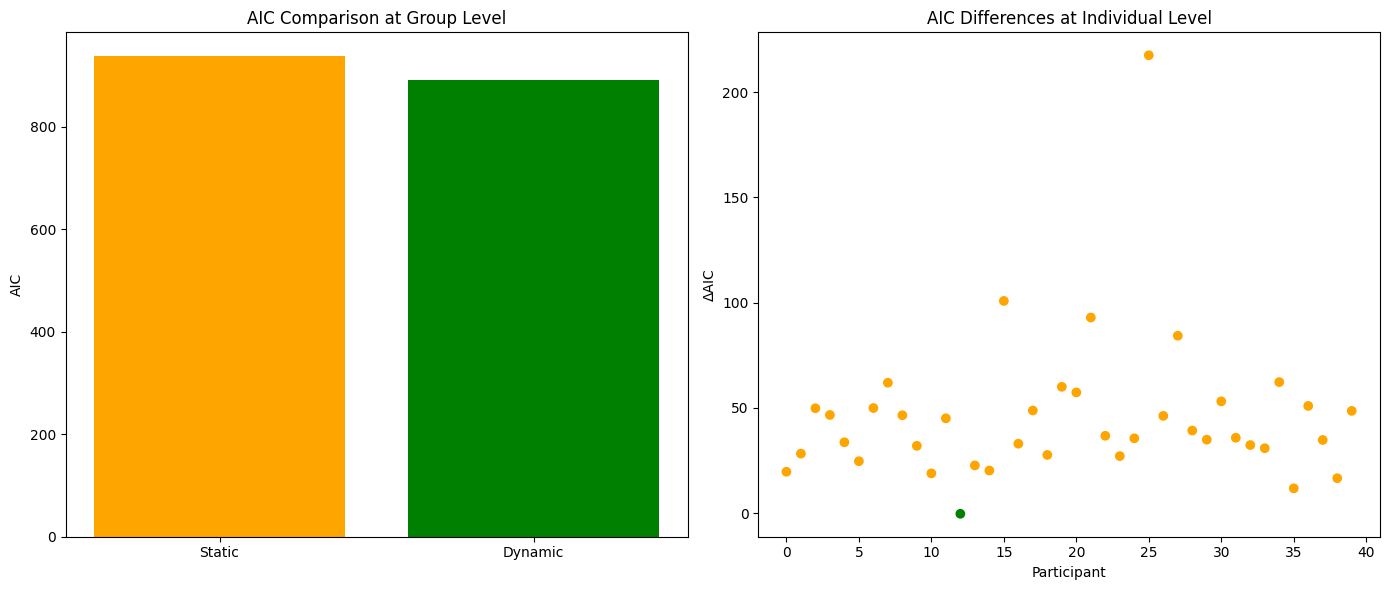

In [18]:
# Calculate the group level AIC difference
group_aic_static = np.mean(individual_aic_static)
group_aic_dynamic = np.mean(individual_aic_dynamic)
group_aic_diff = group_aic_static - group_aic_dynamic

print("Group level AIC for static noise model:", group_aic_static)
print("Group level AIC for dynamic noise model:", group_aic_dynamic)
print("Group level AIC difference:", group_aic_diff)

# Plot the AIC differences at the group and individual levels
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Group level AIC comparison
ax[0].bar(['Static', 'Dynamic'], [group_aic_static, group_aic_dynamic], color=['orange', 'green'])
ax[0].set_ylabel('AIC')
ax[0].set_title('AIC Comparison at Group Level')

# Individual level AIC differences
ax[1].scatter(range(len(aic_diff_individual)), aic_diff_individual, c=['orange' if x > 0 else 'green' for x in aic_diff_individual])
ax[1].set_xlabel('Participant')
ax[1].set_ylabel('ΔAIC')
ax[1].set_title('AIC Differences at Individual Level')

plt.tight_layout()
plt.show()


In [19]:
# Simulate choice behavior using the fitted parameters for validation
def simulate_data(params_static, params_dynamic, n_trials=1000):
    epsilon = params_static[0]
    T_0_1 = params_dynamic[0]
    T_1_0 = params_dynamic[1]

    data_sim = []

    for _ in range(n_trials):
        state = np.random.choice([0, 1], p=[0.5, 0.5])
        if state == 0:
            action = np.random.choice([0, 1, 2], p=[1/3, 1/3, 1/3])
        else:
            action = np.random.choice([0, 1, 2], p=[0.7, 0.15, 0.15])

        correct = (action == 0)  # Assuming action 0 is correct
        reward = correct  # Assuming correct action gets a reward
        rt = np.random.uniform(0.5, 1.5)  # Random reaction time

        data_sim.append([state, action, correct, reward, rt])

    return pd.DataFrame(data_sim, columns=['state', 'action', 'correct', 'reward', 'rt'])

# Simulate data
simulated_data = simulate_data([epsilon_hat], [T_0_1_hat, T_1_0_hat])

# Re-fit the models on the simulated data
result_static_sim = opt.minimize(static_noise_likelihood, [0.5], args=(simulated_data,), bounds=[(0.001, 1)])
epsilon_hat_sim = result_static_sim.x[0]

result_dynamic_sim = opt.minimize(dynamic_noise_likelihood, [0.5, 0.5], args=(simulated_data,), bounds=[(0.001, 1), (0.001, 1)])
T_0_1_hat_sim, T_1_0_hat_sim = result_dynamic_sim.x

print("Recovered static noise model epsilon:", epsilon_hat_sim)
print("Recovered dynamic noise model T_0_1:", T_0_1_hat_sim, "T_1_0:", T_1_0_hat_sim)


KeyError: 'cor'